<a href="https://colab.research.google.com/github/Amzilynn/Stress-Vision/blob/main/StressVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install mediapipe opencv-python matplotlib


  Using cached mediapipe-0.10.31-py3-none-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
Using cached mediapipe-0.10.31-py3-none-manylinux_2_28_x86_64.whl (10.3 MB)


In [22]:
!pip uninstall -y mediapipe
!pip install mediapipe==0.10.14


Found existing installation: mediapipe 0.10.31
Uninstalling mediapipe-0.10.31:
  Successfully uninstalled mediapipe-0.10.31
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 33.5 MB/s eta 0:00:00


In [7]:
!wget -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task
!wget -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_lite/float16/1/pose_landmarker_lite.task


In [8]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/latest/hand_landmarker.task


MediaPipe version: 0.10.14
Processing video...


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Processing frame 30...
Processing frame 60...
Processing frame 90...
Processing frame 120...
Processing frame 150...
Processing frame 180...
Processing frame 210...
Processing frame 240...
Processing frame 270...
Processing frame 300...
Processing frame 330...
Processing frame 360...
Processing frame 390...
Processing frame 420...
Processing frame 450...
Processing frame 480...
Processing frame 510...
Processing frame 540...
Processing frame 570...
Processing frame 600...
Processing frame 630...
Processing frame 660...
Processing frame 690...
Processing frame 720...
Processing frame 750...
Processing frame 780...
Processing frame 810...
Processing frame 840...
Processing frame 870...
Processing frame 900...
Processing frame 930...
Processing frame 960...
Processing frame 990...
Processing frame 1020...
Processing frame 1050...
Processing frame 1080...
Processing frame 1110...
Processing frame 1140...
Processing frame 1170...
Processing frame 1200...
Processing frame 1230...
Processing 

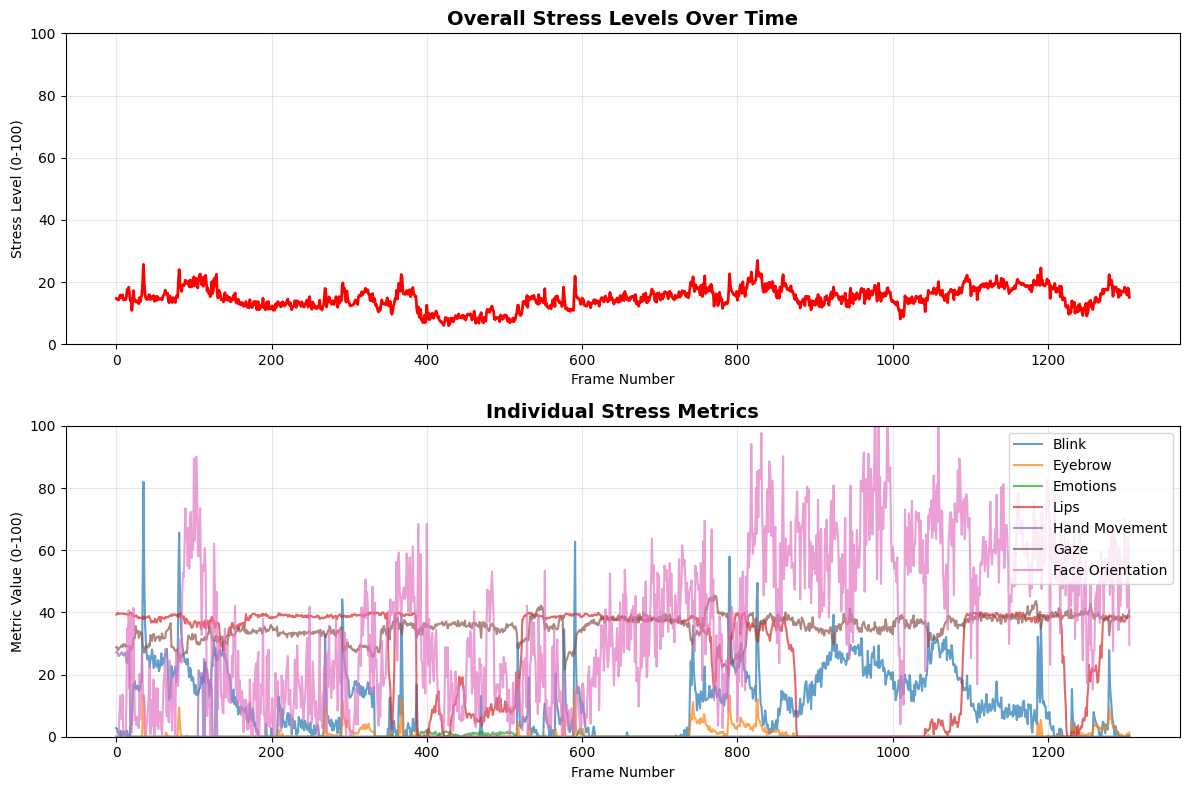


=== Stress Analysis Statistics ===
Average Overall Stress: 14.86
Maximum Stress: 26.94
Minimum Stress: 5.97
Standard Deviation: 3.39


In [2]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp
from mediapipe import tasks
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

print(f"MediaPipe version: {mp.__version__}")

def calculate_stress(blink, eyebrow, emotions, lips, hand_movement, gaze_direction, face_orientation):
    """Calculate overall stress from individual metrics"""
    final_stress = (
        0.15 * blink +
        0.15 * eyebrow +
        0.15 * emotions +
        0.15 * lips +
        0.15 * hand_movement +
        0.15 * gaze_direction +
        0.10 * face_orientation
    )
    return final_stress

def calculate_hand_movement(hand_landmarks):
    """Calculate total hand movement based on landmark distances"""
    if hand_landmarks is None or len(hand_landmarks) == 0:
        return 0

    landmarks = hand_landmarks[0]  # Get first hand
    total_distance = 0

    for i in range(1, len(landmarks)):
        x1, y1, z1 = landmarks[i-1].x, landmarks[i-1].y, landmarks[i-1].z
        x2, y2, z2 = landmarks[i].x, landmarks[i].y, landmarks[i].z
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
        total_distance += distance

    return min(total_distance * 10, 100)  # Normalize to 0-100

def get_landmark_safe(landmarks, index):
    """Safely get a landmark by index"""
    try:
        if landmarks and index < len(landmarks):
            return landmarks[index]
    except (IndexError, AttributeError, TypeError):
        pass
    return None

def analyze_blink(face_landmarks, frame_height):
    """Analyze eye aspect ratio to detect blinks"""
    if face_landmarks is None or len(face_landmarks) == 0:
        return 0

    try:
        landmarks = face_landmarks[0]  # Get first face

        # Left eye landmarks
        left_eye_top = get_landmark_safe(landmarks, 159)
        left_eye_bottom = get_landmark_safe(landmarks, 145)
        left_eye_left = get_landmark_safe(landmarks, 33)
        left_eye_right = get_landmark_safe(landmarks, 133)

        if None in [left_eye_top, left_eye_bottom, left_eye_left, left_eye_right]:
            return 0

        # Calculate eye aspect ratio
        vertical_dist = abs(left_eye_top.y - left_eye_bottom.y)
        horizontal_dist = abs(left_eye_left.x - left_eye_right.x)

        if horizontal_dist > 0:
            ear = vertical_dist / horizontal_dist
            blink_score = max(0, (0.2 - ear) * 500)
            return min(blink_score, 100)
    except Exception as e:
        pass

    return 0

def analyze_eyebrow(face_landmarks):
    """Analyze eyebrow position and movement"""
    if face_landmarks is None or len(face_landmarks) == 0:
        return 0

    try:
        landmarks = face_landmarks[0]

        left_eyebrow_inner = get_landmark_safe(landmarks, 70)
        left_eye = get_landmark_safe(landmarks, 159)
        right_eyebrow_inner = get_landmark_safe(landmarks, 300)
        right_eye = get_landmark_safe(landmarks, 386)

        if None in [left_eyebrow_inner, left_eye, right_eyebrow_inner, right_eye]:
            return 0

        left_height = abs(left_eyebrow_inner.y - left_eye.y)
        right_height = abs(right_eyebrow_inner.y - right_eye.y)
        avg_height = (left_height + right_height) / 2

        eyebrow_score = max(0, (avg_height - 0.03) * 1000)
        return min(eyebrow_score, 100)
    except Exception:
        pass

    return 0

def analyze_emotions(face_landmarks):
    """Analyze facial expressions for emotion indicators"""
    if face_landmarks is None or len(face_landmarks) == 0:
        return 0

    try:
        landmarks = face_landmarks[0]

        left_mouth = get_landmark_safe(landmarks, 61)
        right_mouth = get_landmark_safe(landmarks, 291)
        mouth_center = get_landmark_safe(landmarks, 13)

        if None in [left_mouth, right_mouth, mouth_center]:
            return 0

        left_curve = left_mouth.y - mouth_center.y
        right_curve = right_mouth.y - mouth_center.y
        avg_curve = (left_curve + right_curve) / 2

        emotion_score = max(0, avg_curve * 500)
        return min(emotion_score, 100)
    except Exception:
        pass

    return 0

def analyze_lips(face_landmarks):
    """Analyze lip compression and tension"""
    if face_landmarks is None or len(face_landmarks) == 0:
        return 0

    try:
        landmarks = face_landmarks[0]

        upper_lip = get_landmark_safe(landmarks, 13)
        lower_lip = get_landmark_safe(landmarks, 14)

        if None in [upper_lip, lower_lip]:
            return 0

        lip_distance = abs(upper_lip.y - lower_lip.y)
        lip_score = max(0, (0.02 - lip_distance) * 2000)
        return min(lip_score, 100)
    except Exception:
        pass

    return 0

def analyze_gaze_direction(face_landmarks):
    """Analyze gaze direction and stability"""
    if face_landmarks is None or len(face_landmarks) == 0:
        return 0

    try:
        landmarks = face_landmarks[0]

        left_iris = get_landmark_safe(landmarks, 468)
        left_eye_center = get_landmark_safe(landmarks, 33)

        if None in [left_iris, left_eye_center]:
            return 0

        gaze_deviation = abs(left_iris.x - left_eye_center.x)
        gaze_score = min(gaze_deviation * 500, 100)
        return gaze_score
    except Exception:
        pass

    return 0

def analyze_face_orientation(pose_landmarks):
    """Analyze head pose and orientation"""
    if pose_landmarks is None or len(pose_landmarks) == 0:
        return 0

    try:
        landmarks = pose_landmarks[0]

        nose = get_landmark_safe(landmarks, 0)
        left_shoulder = get_landmark_safe(landmarks, 11)
        right_shoulder = get_landmark_safe(landmarks, 12)

        if None in [nose, left_shoulder, right_shoulder]:
            return 0

        left_dist = abs(nose.x - left_shoulder.x)
        right_dist = abs(nose.x - right_shoulder.x)
        asymmetry = abs(left_dist - right_dist)

        orientation_score = min(asymmetry * 200, 100)
        return orientation_score
    except Exception:
        pass

    return 0



def analyze_video(video_path):
    """Main function to analyze video and extract stress metrics"""


    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return None

    # Initialize MediaPipe models
    try:
        base_options_face = python.BaseOptions(model_asset_path='face_landmarker.task')
        options_face = vision.FaceLandmarkerOptions(
            base_options=base_options_face,
            output_face_blendshapes=False,
            output_facial_transformation_matrixes=False,
            num_faces=1
        )
        face_detector = vision.FaceLandmarker.create_from_options(options_face)

        base_options_hand = python.BaseOptions(model_asset_path='hand_landmarker.task')
        options_hand = vision.HandLandmarkerOptions(
            base_options=base_options_hand,
            num_hands=2
        )
        hand_detector = vision.HandLandmarker.create_from_options(options_hand)

        base_options_pose = python.BaseOptions(model_asset_path='pose_landmarker.task')
        options_pose = vision.PoseLandmarkerOptions(
            base_options=base_options_pose,
            output_segmentation_masks=False
        )
        pose_detector = vision.PoseLandmarker.create_from_options(options_pose)

    except Exception as e:
        print(f"Error initializing MediaPipe models: {e}")
        return None

    stress_data = {
        'blink': [],
        'eyebrow': [],
        'emotions': [],
        'lips': [],
        'hand_movement': [],
        'gaze_direction': [],
        'face_orientation': [],
        'overall': []
    }

    frame_count = 0
    print("Processing video...")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        if frame_count % 30 == 0:
            print(f"Processing frame {frame_count}...")

        try:
            # Convert to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_height = frame.shape[0]

            # Create MediaPipe Image
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

            # Detect landmarks
            face_result = face_detector.detect(mp_image)
            hand_result = hand_detector.detect(mp_image)
            pose_result = pose_detector.detect(mp_image)

            # Extract metrics
            blink = analyze_blink(face_result.face_landmarks, frame_height)
            eyebrow = analyze_eyebrow(face_result.face_landmarks)
            emotions = analyze_emotions(face_result.face_landmarks)
            lips = analyze_lips(face_result.face_landmarks)
            hand_movement = calculate_hand_movement(hand_result.hand_landmarks)
            gaze_direction = analyze_gaze_direction(face_result.face_landmarks)
            face_orientation = analyze_face_orientation(pose_result.pose_landmarks)

            # Store data
            stress_data['blink'].append(blink)
            stress_data['eyebrow'].append(eyebrow)
            stress_data['emotions'].append(emotions)
            stress_data['lips'].append(lips)
            stress_data['hand_movement'].append(hand_movement)
            stress_data['gaze_direction'].append(gaze_direction)
            stress_data['face_orientation'].append(face_orientation)

            # Calculate overall stress
            overall_stress = calculate_stress(
                blink, eyebrow, emotions, lips,
                hand_movement, gaze_direction, face_orientation
            )
            stress_data['overall'].append(overall_stress)

        except Exception as e:
            print(f"Error processing frame {frame_count}: {e}")
            continue

    cap.release()

    print(f"Video analysis complete! Processed {frame_count} frames.")
    return stress_data

def plot_graph(stress_data):
    """Generate and save stress visualization"""
    if not stress_data or len(stress_data['overall']) == 0:
        print("No data to plot!")
        return

    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # Plot overall stress
    axes[0].plot(stress_data['overall'], linewidth=2, color='red')
    axes[0].set_title('Overall Stress Levels Over Time', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Frame Number')
    axes[0].set_ylabel('Stress Level (0-100)')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 100])

    # Plot individual metrics
    axes[1].plot(stress_data['blink'], label='Blink', alpha=0.7)
    axes[1].plot(stress_data['eyebrow'], label='Eyebrow', alpha=0.7)
    axes[1].plot(stress_data['emotions'], label='Emotions', alpha=0.7)
    axes[1].plot(stress_data['lips'], label='Lips', alpha=0.7)
    axes[1].plot(stress_data['hand_movement'], label='Hand Movement', alpha=0.7)
    axes[1].plot(stress_data['gaze_direction'], label='Gaze', alpha=0.7)
    axes[1].plot(stress_data['face_orientation'], label='Face Orientation', alpha=0.7)

    axes[1].set_title('Individual Stress Metrics', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Frame Number')
    axes[1].set_ylabel('Metric Value (0-100)')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 100])

    plt.tight_layout()
    plt.savefig('stress_graph.png', dpi=300, bbox_inches='tight')
    print("Graph saved as 'stress_graph.png'")
    plt.show()

    # Print statistics
    print("\n=== Stress Analysis Statistics ===")
    print(f"Average Overall Stress: {np.mean(stress_data['overall']):.2f}")
    print(f"Maximum Stress: {np.max(stress_data['overall']):.2f}")
    print(f"Minimum Stress: {np.min(stress_data['overall']):.2f}")
    print(f"Standard Deviation: {np.std(stress_data['overall']):.2f}")

if __name__ == "__main__":
    # Update this path to your video file
    video_path = "/content/vd.mp4"

    # Analyze video
    stress_data = analyze_video(video_path)

    # Generate graph
    if stress_data:
        plot_graph(stress_data)